# Tokyo Exchange Stock Price Prediction
Authors: Adam Foster, Maciej Staniszewski

Our project is related to **time series forecasting** of financial product prices using advanced machine learning models - [Facebook Prophet](https://facebook.github.io/prophet/), a univariate additive model that identifies non-linear trends and seasonal effects, and [Uber Orbit](https://github.com/uber/orbit), a probabilistic Bayesian time series modelling framework spanning Exponential Smoothing, Local Global Trend and Damped Local Trend. Our work is [stored on GitHub](https://github.com/afoster28/ml_fin2) in a public repository along with the dataset itself.  

## Data

[The dataset (link to Kaggle)](https://www.kaggle.com/competitions/jpx-tokyo-stock-exchange-prediction/data) contains a list of time series of stock and option prices traded in the Japanese market. The original goal of the exercise was to predict returns, but as this is fully equivalent to predicting the price itself, we decided to chose the latter in favor of price **non-negativity** and **non-stationarity** of observations.

$$return_i = \frac{price_i}{price_{i-1}} - 1$$

### Company of Choice

The focus of our work was a selected stock in the Japanese market: **"Japan Petroleum Exploration Co.,Ltd."**. This is a well established Japanese oil & gas company. It serves as a good starting point for univariate forecasting and restricting our dataset this way allowed us to reduce its original significant size.

## Forecasting Period

As stock prices are generally very dificult to predict, we opted for a (longer than necessary) forecasting period of 45 days, which corresponds to nine business weeks. In our initial expectations we thought that an accurate prediction that far into the future is not feasible, so that time frame was a conservative test of the forecasting libraries that we explored and proved effective.

# Loading and Preparing Data

We first need to load the dataset into the memory of the program. Please note that you can either download the dataset from Kaggle (link in above sections) or pull it from our repository, which stores it using `git lfs` ([Large File Storage](https://git-lfs.com/)).

## Installing and Importing Libraries

If you decide to work in [Google Colab](https://colab.research.google.com/) (like we did) you will need to install some libraries before importing them. Notably, **the stable version of Orbit is not working in Colab**, so you need to explicitly specify the unstable version during the install.

In [ ]:
!pip install prophet # Install Facebook Prophet
!pip install git+https://github.com/uber/orbit.git@dev # Install the dev version of Orbit

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from pylab import rcParams
# Facebook Prophet:
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from prophet.diagnostics import cross_validation
from prophet.plot import plot_cross_validation_metric
# Uber Orbit:
import orbit
from orbit.models import ETS, LGT, DLT
from orbit.diagnostics.plot import plot_predicted_data

As outlined in preceding sections we will define the `FORECASTING_PERIOD` to be 45 days throuought our exercise.

In [54]:
FORECASTING_PERIOD = 45

### Loading the Dataset

We will load the dataset from a `.csv` file and filter it for our comapny of choice. To avoid forecasting issues, we fill missing values by substituting in the previous observation. This is much preferred compared to filling with zeroes, as that avoids introducing discontinuities in the price.

We also create a **train dataset** called `data`, which contains all observations excluding the trailing `FORECASTING_PERIOD`. The complete set, inclusive of 15 testing observations, is defined and called `full`.

In [55]:
data = pd.read_csv('stock_prices.csv') # Read the data from a csv file
data = data.loc[lambda row: row['SecuritiesCode'] == 1662].fillna(method="bfill") # Backfill NAs in the time series of our stock price
data = data.set_index('Date') # Set the index to be the Date for nice plotting
full = data.copy() # Retain the original TEST dataset containing the true last 45 observations
data = data.head(len(data) - FORECASTING_PERIOD) # Train set - test set embedded in 'full' as mentioned above
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1157 entries, 2017-01-04 to 2021-09-29
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   RowId             1157 non-null   object 
 1   SecuritiesCode    1157 non-null   int64  
 2   Open              1157 non-null   float64
 3   High              1157 non-null   float64
 4   Low               1157 non-null   float64
 5   Close             1157 non-null   float64
 6   Volume            1157 non-null   int64  
 7   AdjustmentFactor  1157 non-null   float64
 8   ExpectedDividend  1155 non-null   float64
 9   SupervisionFlag   1157 non-null   bool   
 10  Target            1157 non-null   float64
dtypes: bool(1), float64(7), int64(2), object(1)
memory usage: 100.6+ KB


As seen above, the dataset contains a couple of other time series like `Low`, `High` and `Volume`. We will, however, focus on `Close` only as this is the most accurate representation of the daily value of a stock. We disregard the `Target` series, as that is just a derivative of the price.

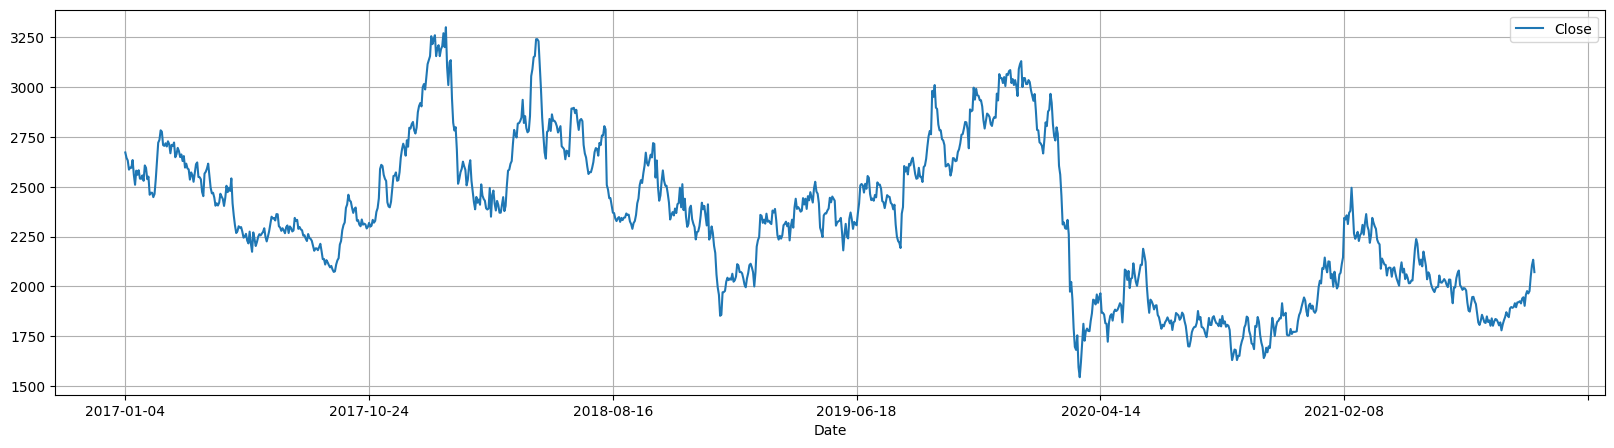

In [56]:
series = data[['Close']] # We are interested in the Close price, as the return can be derived from this variable.
series.plot(grid=True,figsize=(20,5))
plt.show()

## Exploring Data

After loading and plotting our time series, we note the following:
* It is, indeed, continuous and has no missing values,
* It does not appear to be trending deterministically,
* There was a large drop around the beginning of 2020,
* The time series contains a large number of observations from 2017 up to 2022.

### Decomposing into Seasonal Components

We have also decomposed this series into the seasonal components to confirm our hypothesis on the absence of deterministic trends and to get more information about other components of this series. We decided to use **the additive model** in order to model the stock price, as the seasonal components are linear shifts of one another.

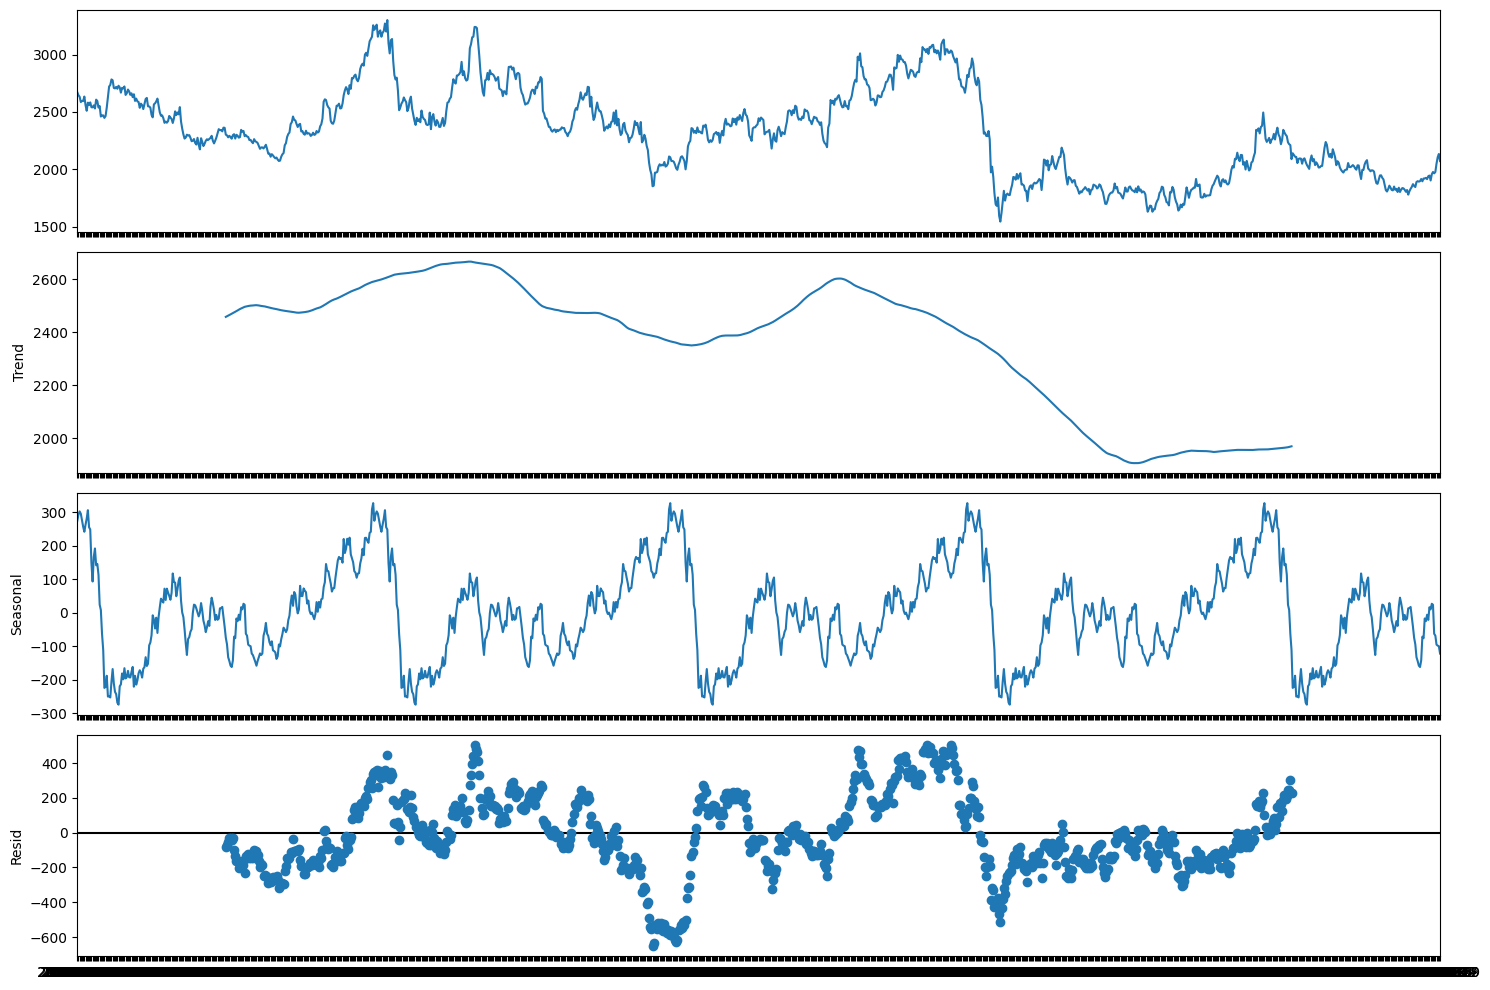

In [90]:
rcParams['figure.figsize'] = 15, 10 # Increasing the size of the plots
# Using the multiplicative model, because this is a stock price following the exponential GBM.
# The number of business (trading) days in a year is 252.
decomposition = sm.tsa.seasonal_decompose(series, model = 'additive', period=252)
fig = decomposition.plot()
plt.show()

With the above chart we are satisfied to confirm the absence of deterministic trends in the series. We observe a strongly-repeating seasonal component tied to the yearly cycle of the stock market. As a reminder, our data is covering five years (2017 - 2022), each of them represented in the *Seasonal* component series. The residuals are oscillating around 0.0, which is as expected for an additive model.

# Forecasting with Prophet

To leverage *Prophet* we first need to prepare the series by creating a data frame with two columns - `ds` (dates) and `y` (values). This is then used in the typical fit-predict-evaluate pipeline.

## Constructing the Model

After creating the `s` dataframe we construct the model `m`, which accounts for Japanese holidays.

In [91]:
s = series.reset_index() # We don't want any indices in the Prophet dataframe
s.columns = [ 'ds', 'y' ] # We have to rename our columns to match Prophet specifications
m = Prophet(interval_width=0.95, seasonality_mode = "additive") # We chose our conficence interval to be 95% as opposed to 80%.
m.add_country_holidays(country_name='JP') # We account for Japanese holidays.

model = m.fit(s) # The actual model fit without daily seasonality (our data is daily too)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


## Defining the Future Dataframe

The future dataframe will contain all samples that the forecasting mechanism performs. It is exactly 45 rows longer than the `data` dataframe, it's number of rows must be equal to the number of rows in the `full` dataframe.

In [92]:
# Last observations in the `data` set end on 29-09-2021
data.tail()

,RowId,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
Date,,,,,,,,,,,
2021-09-22,20210922_1662,1662,1974.0,1985.0,1960.0,1977.0,195700,1.0,25.0,False,0.027317
2021-09-24,20210924_1662,1662,2028.0,2050.0,2026.0,2050.0,279000,1.0,25.0,False,0.013295
2021-09-27,20210927_1662,1662,2091.0,2115.0,2080.0,2106.0,221000,1.0,25.0,False,-0.029053
2021-09-28,20210928_1662,1662,2138.0,2150.0,2101.0,2134.0,307000,1.0,NaN,False,0.013514
2021-09-29,20210929_1662,1662,2103.0,2104.0,2040.0,2072.0,239300,1.0,NaN,False,-0.006190


In [93]:
future = m.make_future_dataframe(periods=45)
# Last `future` observations placeholders end on 26-12-2021, exactly after 45 days:
future.tail()

,ds
1197,2021-11-09
1198,2021-11-10
1199,2021-11-11
1200,2021-11-12
1201,2021-11-13


## Predicting using Prophet

After the preparations are complete, we use the model for out-of-sample prediction:

In [94]:
forecast = m.predict(future)
forecast[['ds', 'yhat']].tail() # Notice how the placeholder dates now store predicted samples!

,ds,yhat
1197,2021-11-09,2118.779858
1198,2021-11-10,2120.125085
1199,2021-11-11,2118.707990
1200,2021-11-12,2120.295233
1201,2021-11-13,2244.495645


We can plot the whole series, including the last 45 predicted days, accounting for *changepoints* - these are special moments in which the model observes a significant change in the current trend.

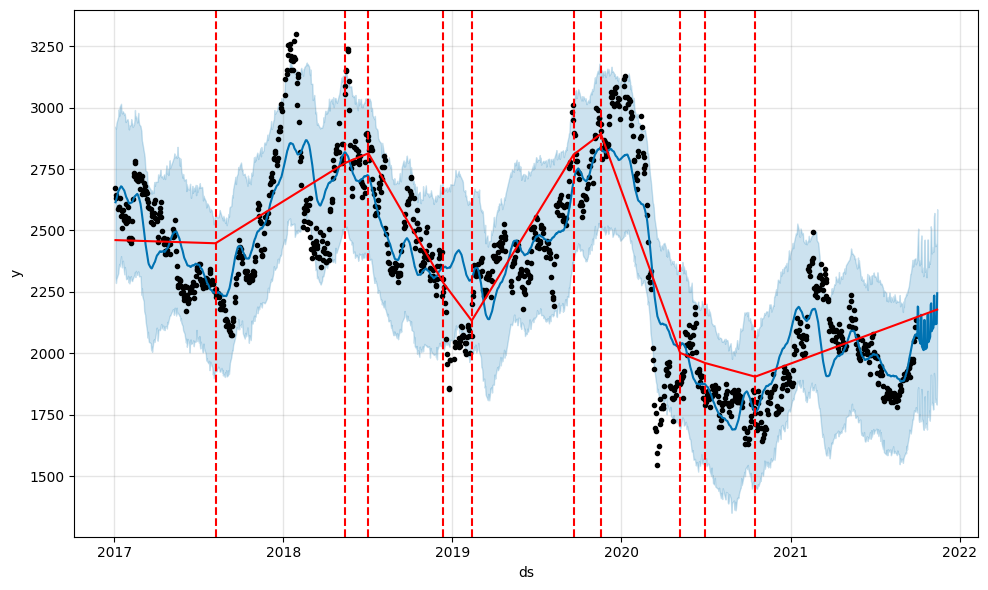

In [95]:
plot1 = m.plot(forecast)
a = add_changepoints_to_plot(plot1.gca(),m,forecast)

### Components of the Forecast

Similarly to how we explored the input dataset, we will now take a look at how *Prophet* decomposes the series into consituents. Notably, it will account for Japanese holidays, as we specified before.

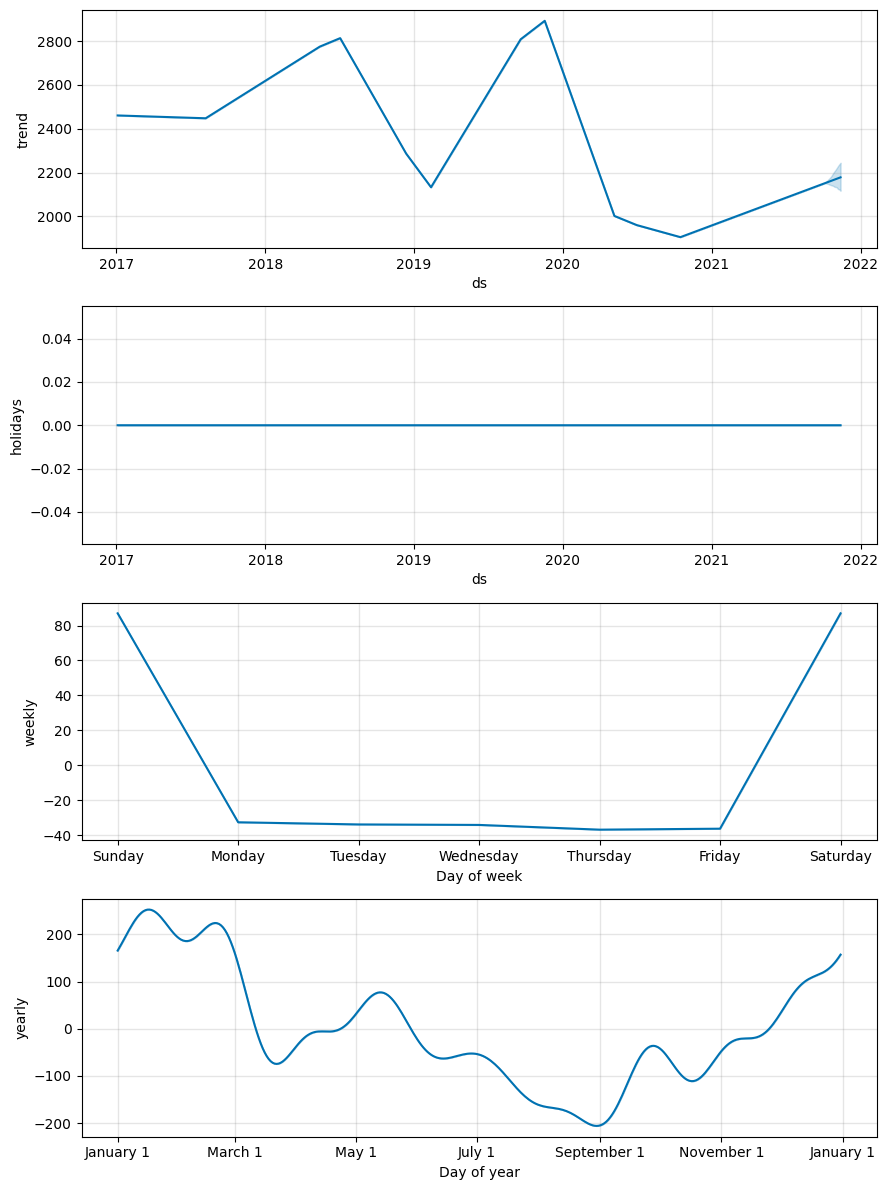

In [96]:
plot2 = m.plot_components(forecast)

Importantly, the stock market is closed during holidays, so this component has no effect on the prediction. The weekly component is clearly separating the working weeks from weekends, during which the market closes. This is as expected. We are also happy to see that the workdays do not differ in parameter magnitudes - there should be no preference in trading between those days.

## Evaluating Prophet

To evaluate our forecast we neet to combine our predictions with the `full` dataset containing our testing data.

In [97]:
# Create columns with uniform date format ahead of joining:
full['ds'] = pd.to_datetime(full.index, utc = True)
forecast['ds'] = pd.to_datetime(forecast['ds'], utc = True)
# Perform the join on the date timestamp:
df_merge = pd.merge(full, forecast[['ds','yhat_lower','yhat_upper','yhat']], on='ds')
df_merge = df_merge[['ds','yhat_lower','yhat_upper','yhat','Close']]
# Show the head of the joined dataset comparing Close with yhat
df_merge.tail(10)

,ds,yhat_lower,yhat_upper,yhat,Close
1178,2021-10-29 00:00:00+00:00,1769.784809,2389.782639,2067.299288,2077.0
1179,2021-11-01 00:00:00+00:00,1791.810484,2406.294699,2089.649665,2118.0
1180,2021-11-02 00:00:00+00:00,1799.103392,2410.946813,2093.964716,2120.0
1181,2021-11-04 00:00:00+00:00,1771.148116,2412.771200,2100.667814,2085.0
1182,2021-11-05 00:00:00+00:00,1773.117761,2413.784642,2105.286465,2076.0
1183,2021-11-08 00:00:00+00:00,1802.013687,2453.143231,2117.983599,2208.0
1184,2021-11-09 00:00:00+00:00,1815.094028,2435.700167,2118.779858,2272.0
1185,2021-11-10 00:00:00+00:00,1814.176446,2440.593594,2120.125085,2371.0
1186,2021-11-11 00:00:00+00:00,1795.844674,2441.769423,2118.707990,2338.0
1187,2021-11-12 00:00:00+00:00,1791.032605,2447.879239,2120.295233,2320.0


To put a number on prediction error we will use Mean Absolute Error and Mean Absolute Percentage Error.

MAE: 124.814
MAPE: 0.054


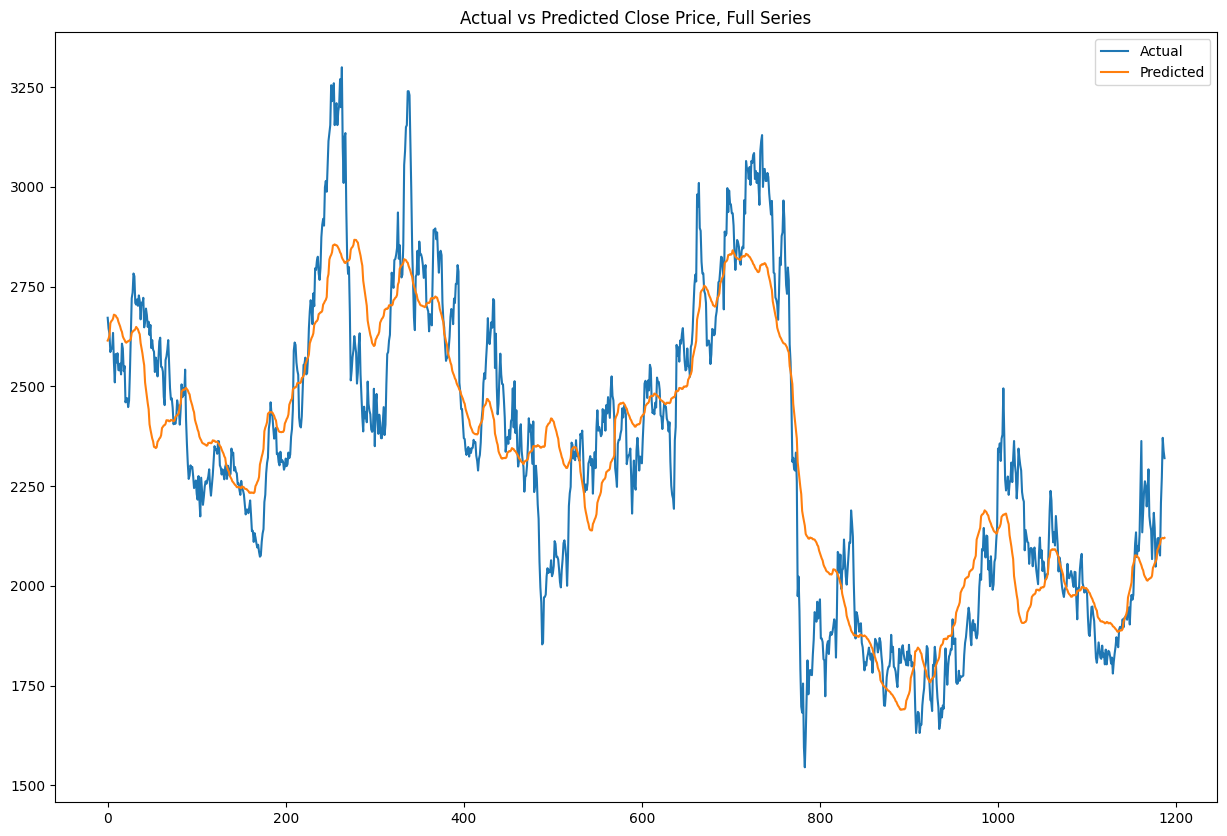

In [98]:
y_true = df_merge['Close'].values
y_pred = df_merge['yhat'].values
mae_01 = mean_absolute_error(y_true, y_pred)
print('MAE: %.3f' % mae_01)
mape_01 = mean_absolute_percentage_error(y_true, y_pred)
print('MAPE: %.3f' % mape_01)

# plot expected vs actual
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title("Actual vs Predicted Close Price, Full Series")
plt.legend()
plt.show()

We obtained a MAPE of **5.4%**, which is **extremely good**. This is, however, because we're using the full series for evaluation. Let's see what will we get if we restrict our period to the last 45 observations:

MAE (forecasting): 100.593
MAPE (forecasting): 0.046


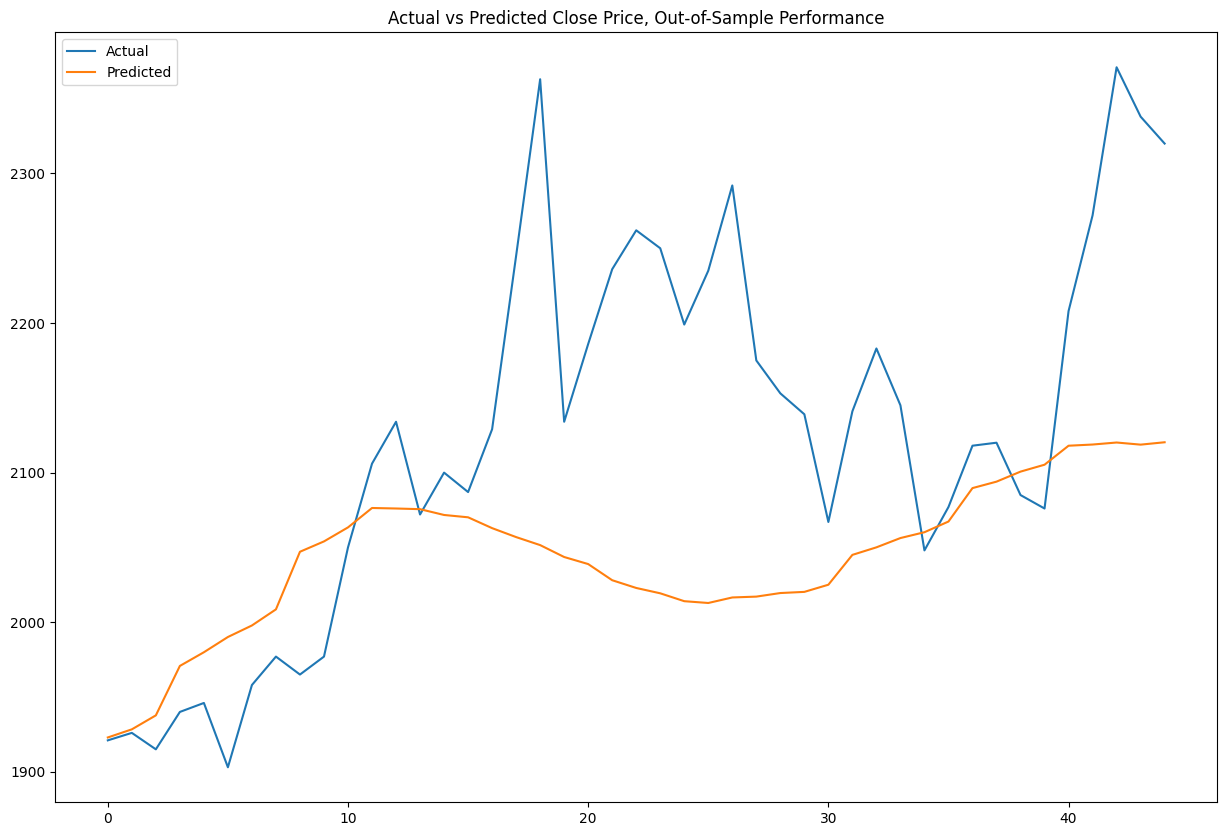

In [99]:
y_true = df_merge.tail(FORECASTING_PERIOD)['Close'].values
y_pred = df_merge.tail(FORECASTING_PERIOD)['yhat'].values
mae_01 = mean_absolute_error(y_true, y_pred)
print('MAE (forecasting): %.3f' % mae_01)
mape_01 = mean_absolute_percentage_error(y_true, y_pred)
print('MAPE (forecasting): %.3f' % mape_01)
# plot expected vs actual
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title("Actual vs Predicted Close Price, Out-of-Sample Performance")
plt.legend()
plt.show()

This is even better. It turns out, that Prophet fits extreme spikes worse, limiting our MAPE score, but our out-of-sample period is better fitted by our model bringing MAPE down to **4.6%**.

## Conclusions

Prophet is an amazing tool, which can very accurately predict future values of the time series with minimal setup required. We were able to obtain a MAPE score of 4.6% on out-of-sample data, which is very impressive for real-world stock market data, particularly this far into the future.

## Cross Validation

We wanted to see if the good performance we observed was accidental, or if it was a true reflection of Prophet capabilities. After all, had we encountered an out-of-sample spike, the model could have performed worse on average. To test that hypothesis we ran a CV routine which trained the model using 800 days and predicted 45 1-day forecast Close prices in parallel.

**WARNING:** This may take a while! Ensure you're running in an environment with lots of CPU power, like Google Colab.

In [100]:
df_cv = cross_validation(m, initial='800 days', period='1 day', horizon = '45 days', parallel='threads')

INFO:prophet:Making 885 forecasts with cutoffs between 2019-03-15 00:00:00 and 2021-08-15 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.thread.ThreadPoolExecutor object at 0x7a74c4e3cd90>


In [101]:
df_cv.tail()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
26438,2021-09-22,2065.210092,1748.257000,2359.245676,1977.0,2021-08-15
26439,2021-09-24,2072.829398,1754.725639,2412.790849,2050.0,2021-08-15
26440,2021-09-27,2083.056694,1746.704235,2377.165900,2106.0,2021-08-15
26441,2021-09-28,2082.072337,1760.533454,2399.208383,2134.0,2021-08-15
26442,2021-09-29,2080.603450,1794.228939,2381.492542,2072.0,2021-08-15


### CV Metrics

We will now evaluate cross validation results we got and plot in on a chart. The chart shows all 45 days of our out-of-sample prediction and associated MAPE for a prediction of a given length.

In [102]:
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.tail()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
36,41 days,160981.290901,401.224739,281.287662,0.137075,0.093058,0.133726,0.696197
37,42 days,163293.324033,404.095687,283.181328,0.138112,0.092414,0.134675,0.695144
38,43 days,166074.355243,407.522214,285.529262,0.139386,0.093675,0.135848,0.694493
39,44 days,168963.770840,411.052029,287.906398,0.140653,0.092689,0.137025,0.693806
40,45 days,171941.584118,414.658394,290.284545,0.141901,0.091328,0.138183,0.693862


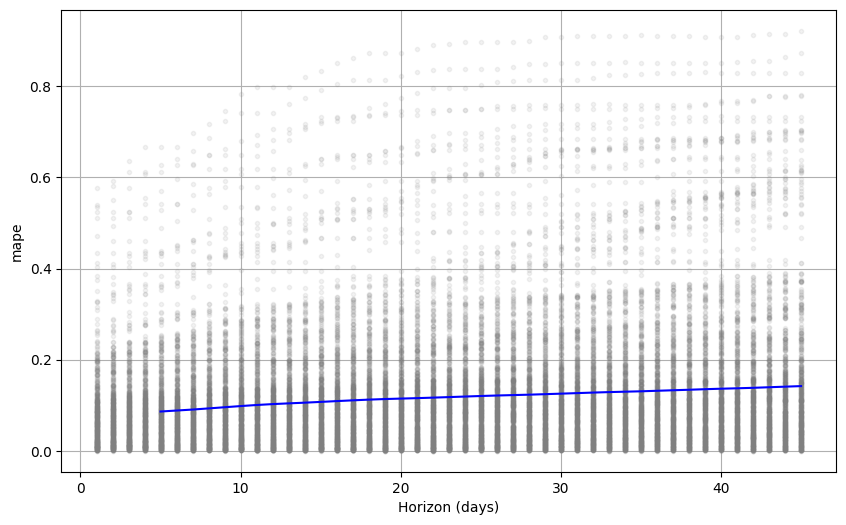

In [103]:
plot4 = plot_cross_validation_metric(df_cv, metric='mape')

Looking at the plot above we can conclude, that the model does not perform as well for all possible cross-validated prediction intervals. The MAPE error is higher than 15% and lower than 20% for a 45-day prediction. Notably, if we decided to employ this solution in production for a smaller forecasting period, we could brind the MAPE down to around 10% by using a 5-day prediction window.

## Saving the Model

We can save our model to the `.json` file as recommended by Prophet. Notably, this functionality seems to not work in Google Colab, but should work locally.

In [104]:
import json
from prophet.serialize import model_to_json, model_from_json
with open('prophet_model.json', 'w') as fout:
    json.dump(model_to_json(m), fout)  # Save model

## Tuning

We would like to tune the model hyperparameters to see if we can reasonably expect a better outcome with our compute resources. To do that we will grid search for the best combination of `changepoint_prior_scale` and `seasonality_prior_scale` components of the model. However, we expect Prophet to pick appropriate values for those parameters for us, so this cross validation is for additional information only.

In [105]:
# Python
import itertools

param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.2, 0.5],
    'seasonality_prior_scale': [0.001, 0.01, 0.1, 1.0, 5.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
maes = []  # Store the MAE for each params here
mapes = [] # Store the MAPE for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(s)  # Fit model with given params
    df_cv = cross_validation(m, horizon='90 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    maes.append(df_p['mae'].values[0])
    mapes.append(df_p['mape'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['mae'] = maes
tuning_results['mape'] = mapes

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 29 forecasts with cutoffs between 2018-01-18 00:00:00 and 2021-07-01 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7a74cb345660>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 29 forecasts with cutoffs between 2018-01-18 00:00:00 and 2021-07-01 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7a74c4f4dd50>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 29 forecasts with cutoffs between 2018-01-18 00:00:00 and 2021-07-01 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7a74c5f39e10>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_se

In [106]:
tuning_results_df = pd.DataFrame(tuning_results)
tuning_results_df.sort_values(['mape','mae'])

,changepoint_prior_scale,seasonality_prior_scale,mae,mape
0,0.001,0.001,271.164667,0.124598
19,0.200,0.010,291.740578,0.130753
25,0.500,0.010,296.124329,0.133554
13,0.100,0.010,320.915240,0.144422
22,0.200,5.000,335.742090,0.149277
20,0.200,0.100,336.649819,0.149836
23,0.200,10.000,338.582325,0.150731
21,0.200,1.000,339.443400,0.151357
26,0.500,0.100,353.461988,0.155644
5,0.001,10.000,343.203625,0.158032


We observe that the smaller the two parameters the better - notably, the overfitting risk was too big for us to go for this small benefit in MAPE.

In [107]:
best_params = all_params[np.argmin(mapes)]
print(best_params)

{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.001}


# Orbit

We will now compare our *Prophet* results with an alternative framework - Uber Orbit.

## Preparations and Setup

Similarly to before, we start by constructing train/test split datasets. This time, instead of a train and a full dataset, we will have to provide Orbit with training and testing data separately.

In [108]:
full['Date'] = full.index
train_df = full[:-FORECASTING_PERIOD]
test_df = full[-FORECASTING_PERIOD:]

## Exponential Smoothing

Exponential Smoothing is a State Space Model; process is generally expressed as:

$$ y_t = Z_t^T \alpha_t + \varepsilon_t $$

$$ \alpha_{t+1} = T_t \alpha_t + R_t \eta_t $$

Where the first equation (prediction equation) is used to forecast, typically using linear regression, and the second (update equation) is responsible for the update to the state vector of the model with some variance in state evolution itself.

We will use Markov Chain Monte Carlo method to estimate this exponential smoothing model and fit our data.

In [109]:
ets = ETS(
    response_col='Close',
    date_col='Date',
    seasonality=360, #yearly
    seed=2024,
    estimator="stan-mcmc",
    stan_mcmc_args={'show_progress': True},
)

ets.fit(df=train_df)

2024-01-14 22:45:41 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

## Predicting using Orbit

We will now perform out-of-sample prediction on 45 days, similarly to how it was done using Prophet. Orbit also supports the typical fit-predict-evaluate pipeline, so the code is relatively similar.

In [110]:
predicted_df = ets.predict(df=test_df) # Predict using Orbit

## Assessment of the Smoothing Model

We will compute MAE and MAPE again, this time for our Orbit results:

In [113]:
# Prepare date columns for merging:
full['ds'] = pd.to_datetime(full.index, utc = True)
predicted_df['ds'] = pd.to_datetime(predicted_df['Date'], utc = True)
# Merge the actual datasets:
df_merge = pd.merge(full, predicted_df, on='ds')
df_merge = df_merge[['ds','prediction', 'Close']]
df_merge.head(10)

,ds,prediction,Close
0,2021-09-30 00:00:00+00:00,2070.146458,2100.0
1,2021-10-01 00:00:00+00:00,2060.700832,2087.0
2,2021-10-04 00:00:00+00:00,2066.073355,2129.0
3,2021-10-05 00:00:00+00:00,2072.939533,2245.0
4,2021-10-06 00:00:00+00:00,2054.851794,2363.0
5,2021-10-07 00:00:00+00:00,2059.287556,2134.0
6,2021-10-08 00:00:00+00:00,2060.933665,2186.0
7,2021-10-11 00:00:00+00:00,2046.022355,2236.0
8,2021-10-12 00:00:00+00:00,2045.401096,2262.0
9,2021-10-13 00:00:00+00:00,2060.651780,2250.0


In [114]:
# Calculate out-of-sample MAPE
y_true = df_merge['Close'].values
y_pred = df_merge['prediction'].values
mae_01 = mean_absolute_error(y_true, y_pred)
print('MAE: %.3f' % mae_01)
mape_01 = mean_absolute_percentage_error(y_true, y_pred)
print('MAPE: %.3f' % mape_01)

MAE: 152.685
MAPE: 0.067


We see that the prediction is a bit worse this time, but still very impressive. The MAPE score is equal to **6.7%**, which is a very low number for real world financial data. We will also like to plot obtained results to compare the two series visually:

<Axes: >

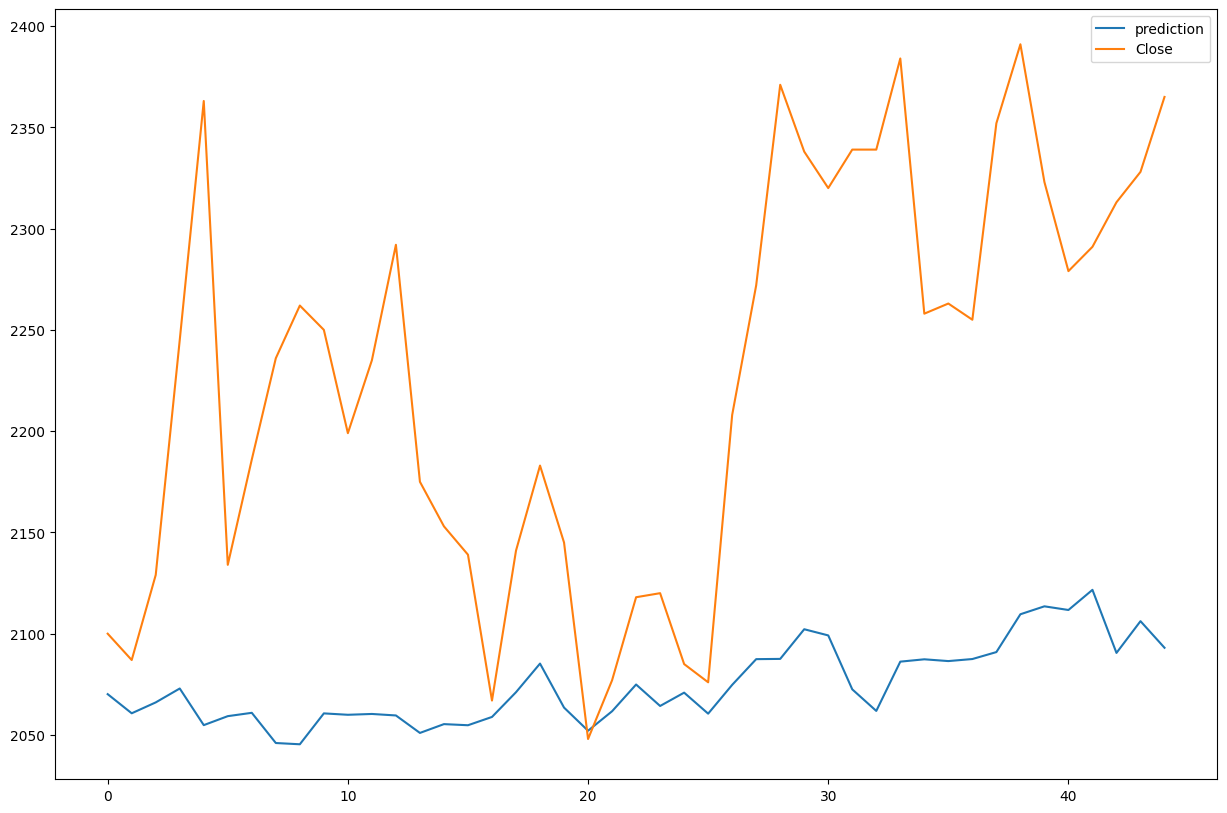

In [116]:
df_merge[['prediction', 'Close']].plot()

Predicted result does not properly pick up the sudden jump in the underlying asset price, which is the main difference compared to the result produced by Prophet.

## Local Global Trend Model

Similarly to exponential smoothing, we will now employ the LGT model from the Orbit package and evaluate it in the similar way.

2024-01-14 22:54:38 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

                                                                                                                                                                                                                                                                                                                                                                                                                
MAE: 163.561
MAPE: 0.072


<Axes: >

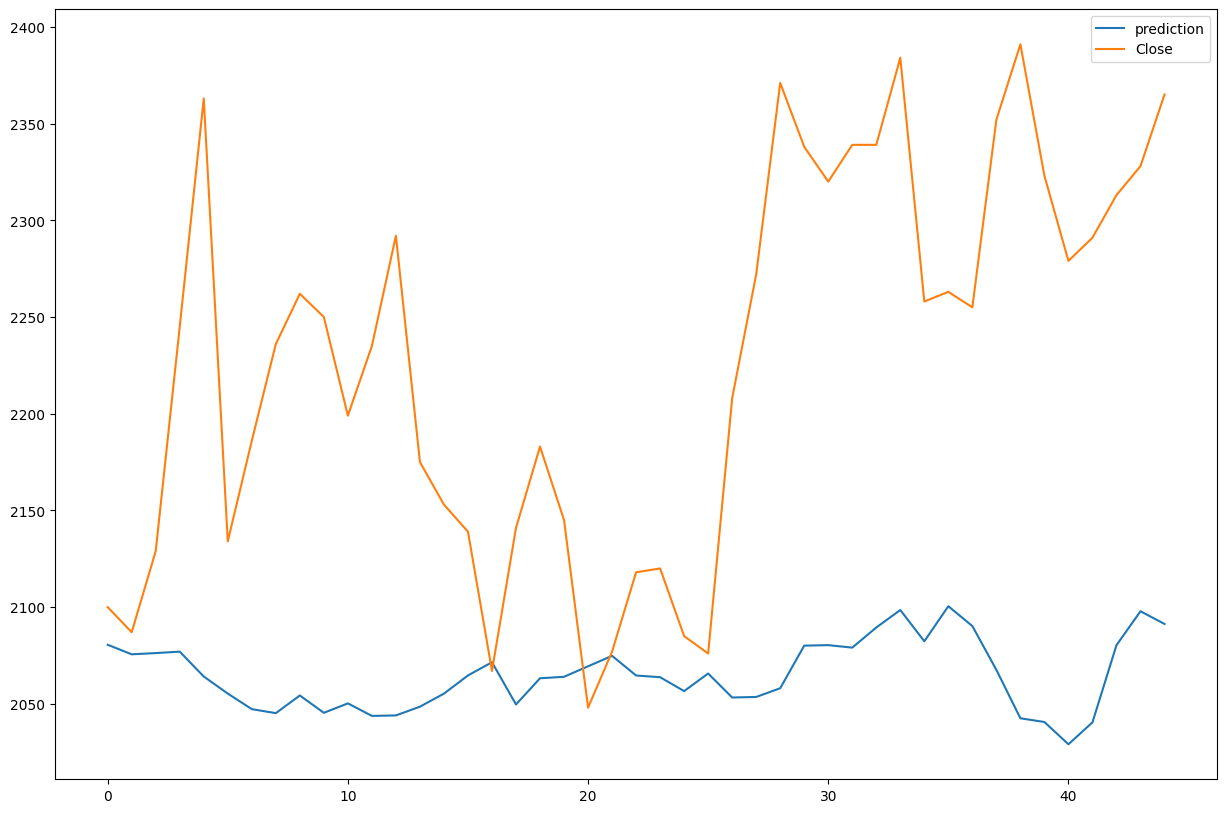

In [120]:
lgt = LGT(
    response_col='Close',
    date_col='Date',
    estimator='stan-mcmc', # Markov Chain Monte Carlo
    seasonality=365,
    seed=8888,
)
lgt.fit(df=train_df) #Fit the model
predicted_df = lgt.predict(df=test_df) # Predict with LGT
# Merge results with actual data:
full['ds'] = pd.to_datetime(full.index, utc = True)
predicted_df['ds'] = pd.to_datetime(predicted_df['Date'], utc = True)

df_merge = pd.merge(full, predicted_df, on='ds')
df_merge = df_merge[['ds','prediction', 'Close']]
# Calculate out-of-sample MAPE
y_true = df_merge['Close'].values
y_pred = df_merge['prediction'].values
mae_01 = mean_absolute_error(y_true, y_pred)
print('MAE: %.3f' % mae_01)
mape_01 = mean_absolute_percentage_error(y_true, y_pred)
print('MAPE: %.3f' % mape_01)
# Plot:
df_merge[['prediction', 'Close']].plot()

### Evaluation

The score is a bit worse than Prophet again, but the series is visually more reactive to the jump in the underlying price around index 25.

### MAP Score

We have also tested the LGT Model with Maximum A-Posteriori (MAP) score, but the out-of-sample MAPE result was similar, so we decided against including this analysis in our final report.

## Damped Local Trend (DLT)

We repeat our analysis for the third state space model.

2024-01-14 23:00:35 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.
INFO:orbit:Optimizing (PyStan) with algorithm: LBFGS.


MAE: 157.473
MAPE: 0.069


<Axes: >

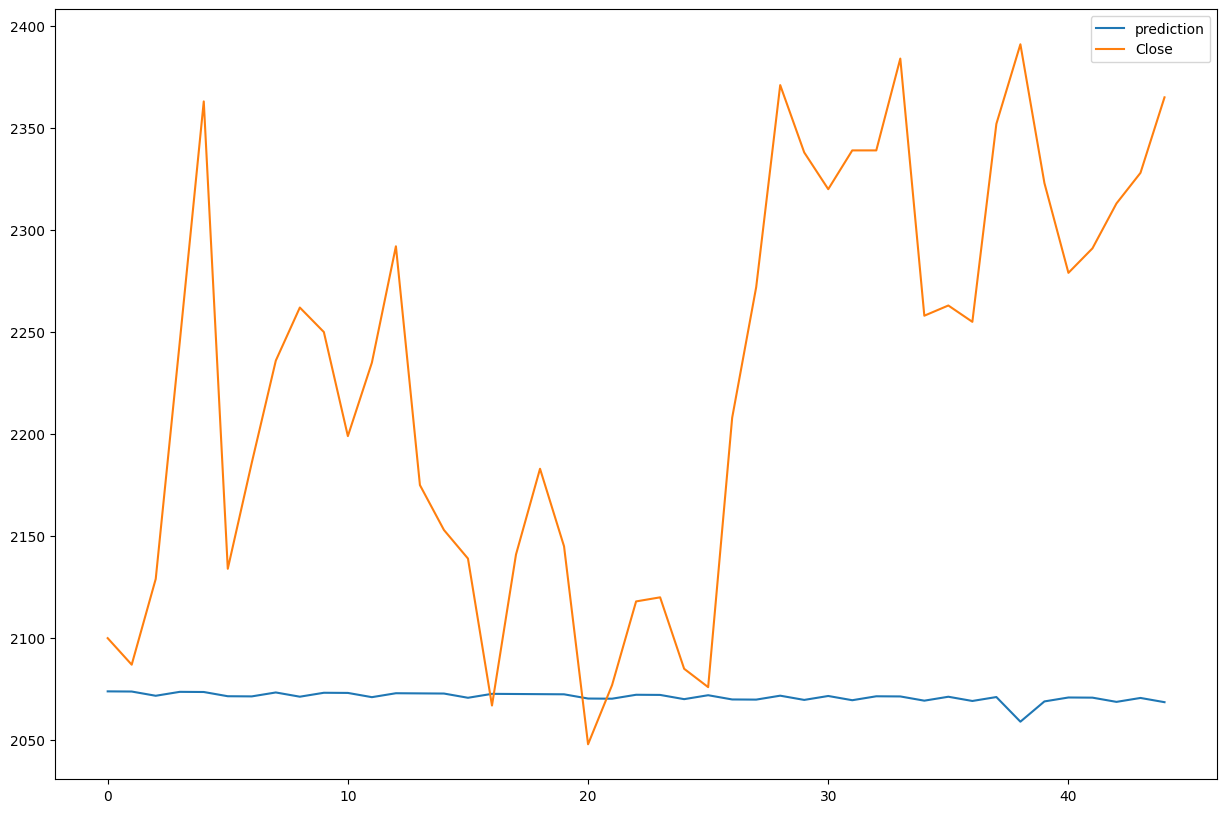

In [122]:
dlt = DLT(
    response_col='Close',
    date_col='Date',
    estimator='stan-map',
    seasonality=52,
    seed=8888,
    global_trend_option='loglinear', # Hoping to model the exponential nature of the stock price as per GBM
    # for prediction uncertainty
    n_bootstrap_draws=1000,
)

dlt.fit(df=train_df) # Fitting the model

predicted_df = dlt.predict(df=test_df) # Predict with DLT
# Merge results with actual data:
full['ds'] = pd.to_datetime(full.index, utc = True)
predicted_df['ds'] = pd.to_datetime(predicted_df['Date'], utc = True)

df_merge = pd.merge(full, predicted_df, on='ds')
df_merge = df_merge[['ds','prediction', 'Close']]
# Calculate out-of-sample MAPE
y_true = df_merge['Close'].values
y_pred = df_merge['prediction'].values
mae_01 = mean_absolute_error(y_true, y_pred)
print('MAE: %.3f' % mae_01)
mape_01 = mean_absolute_percentage_error(y_true, y_pred)
print('MAPE: %.3f' % mape_01)
# Plot:
df_merge[['prediction', 'Close']].plot()

# Summary of the Project

Concluding our project we summarize, that *Prophet* is a great tool for time series forecasting requiring minimal setup. Our MAPE score was lower than 5% for an out-of-sample forecast of 45 days on real-world stock data. Uber Orbit performed very well too, but MAPE was higher at around 7% in all three models tested, including exponential smoothing, local global trend and damped local trend models. Our promising results were backed by extensive cross validation. Notably, with a smaller prediction window one could reduce those errors even further.

In [133]:
#!apt install jq
#!jq -M 'del(.metadata.widgets)' rep.ipynb > rep.fixed.ipynb
#!jupyter nbconvert --to html rep.fixed.ipynb --output-dir=/content/
#!pwd

[NbConvertApp] Converting notebook rep.fixed.ipynb to html
[NbConvertApp] Writing 2147834 bytes to /content/rep.fixed.html
